In [ ]:
!pip install nibabel tqdm opencv-python
import os
import numpy as np
import nibabel as nib # Import nibabel for NIfTI file handling
from tqdm import tqdm # Import tqdm for progress bar
import cv2 # Import cv2 for image resizing
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [ ]:
# Set paths for data directories
train_ct_path = r"/content/volume-110.nii"
train_mask_path = r"/content/segmentation-110.nii"
test_ct_path = r"/content/volume-121.nii"
test_mask_path = r"/content/segmentation-121.nii"


#Preprocessing
def process_nifti_files(ct_path, mask_path, output_path, is_training=True):
    """
    Process .nii files and convert them to normalized numpy arrays
    """
    # Create output directories if they don't exist
    os.makedirs(output_path, exist_ok=True)
    ct_output = os.path.join(output_path, 'ct_scans')
    mask_output = os.path.join(output_path, 'masks')
    os.makedirs(ct_output, exist_ok=True)
    os.makedirs(mask_output, exist_ok=True)

    #  The paths are to single files, not to directories containing .nii files.
    #  Remove the attempt to list files in the directory:
    #ct_files = sorted([f for f in os.listdir(ct_path) if f.endswith('.nii')])
    #print(ct_files)
    print(f"Processing {'training' if is_training else 'testing'} data...")

    # Process the single provided NIfTI file
    try:
        # Load CT scan using nibabel
        ct_nifti = nib.load(ct_path)
        ct_data = ct_nifti.get_fdata()

        # Load corresponding mask using nibabel
        mask_nifti = nib.load(mask_path)
        mask_data = mask_nifti.get_fdata()

        # Normalize CT data to 0-1 range
        ct_data = (ct_data - ct_data.min()) / (ct_data.max() - ct_data.min())

        # Convert mask to binary (0 or 1)
        mask_data = (mask_data > 0).astype(np.float32)

        # Save each slice as a separate file
        for slice_idx in range(ct_data.shape[2]):
            ct_slice = ct_data[:,:,slice_idx]
            mask_slice = mask_data[:,:,slice_idx]

            # Resize to standard size (e.g., 256x256)
            ct_slice = cv2.resize(ct_slice, (256, 256))
            mask_slice = cv2.resize(mask_slice, (256, 256))

            # Save as numpy arrays
            slice_name = f"{os.path.basename(ct_path).split('.')[0]}_slice_{slice_idx}" # Use os.path.basename to get filename
            np.save(os.path.join(ct_output, f"{slice_name}.npy"), ct_slice)
            np.save(os.path.join(mask_output, f"{slice_name}.npy"), mask_slice)

    except Exception as e:
        print(f"Error processing {ct_path}: {str(e)}")

# Process training data
train_output = r"processed_data/train" # Change path separator to forward slash
process_nifti_files(train_ct_path, train_mask_path, train_output, is_training=True)

# Process testing data
test_output = r"processed_data/test" # Change path separator to forward slash
process_nifti_files(test_ct_path, test_mask_path, test_output, is_training=False)

print("\nData processing complete!")

Processing training data...
Processing testing data...

Data processing complete!


In [ ]:
# Create data generators for training
def create_data_generator(data_path, batch_size=32):
    ct_path = os.path.join(data_path, 'ct_scans')
    mask_path = os.path.join(data_path, 'masks')

    ct_files = sorted([f for f in os.listdir(ct_path) if f.endswith('.npy')])

    while True:
        # Shuffle files at the start of each epoch
        np.random.shuffle(ct_files)

        for i in range(0, len(ct_files), batch_size):
            batch_files = ct_files[i:i + batch_size]

            ct_batch = []
            mask_batch = []

            for f in batch_files:
                ct = np.load(os.path.join(ct_path, f))
                mask = np.load(os.path.join(mask_path, f))

                ct_batch.append(ct)
                mask_batch.append(mask)

            ct_batch = np.array(ct_batch)
            mask_batch = np.array(mask_batch)

            # Add channel dimension if needed
            ct_batch = np.expand_dims(ct_batch, -1)
            mask_batch = np.expand_dims(mask_batch, -1)

            yield ct_batch, mask_batch

# Create generators
train_generator = create_data_generator("processed_data/train")
test_generator = create_data_generator("processed_data/test")

print("Data generators created and ready for model training!")

# Custom Dice coefficient metric
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    # Flatten the tensors
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)

    # Compute the intersection and union
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


# Define the U-Net model architecture
def build_unet_model(input_shape=(256, 256, 1)):
    inputs = Input(input_shape)

    # Encoder (Contracting Path)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bridge
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder (Expanding Path)
    up5 = concatenate([Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4), conv3], axis=3)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5), conv2], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6), conv1], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile the model
model = build_unet_model()
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy', dice_coefficient])

model.summary()


Data generators created and ready for model training!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 64, 64, 256)    │        524,544 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 512)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 256)    │      1,179,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 128, 128, 128)  │        131,200 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)    

 Total params: 7,696,193 (29.36 MB)

 Trainable params: 7,696,193 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

12
7
Epoch 1/2
12/12 ━━━━━━━━━━━━━━━━━━━━ 2376s 200s/step - accuracy: 0.9533 - dice_coefficient: 0.0225 - loss: 0.5297 - val_accuracy: 0.9813 - val_dice_coefficient: 2.4992e-06 - val_loss: 0.2522 - learning_rate: 0.0010
Epoch 2/2


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_dice available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_dice` which is not available. Available metrics are: accuracy,dice_coefficient,loss,val_accuracy,val_dice_coefficient,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_dice` which is not available. Available metrics are: accuracy,dice_coefficient,loss,val_accuracy,val_dice_coefficient,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2380s 201s/step - accuracy: 0.9854 - dice_coefficient: 0.0044 - loss: 0.1295 - val_accuracy: 0.9862 - val_dice_coefficient: 0.0211 - val_loss: 0.0632 - learning_rate: 0.0010


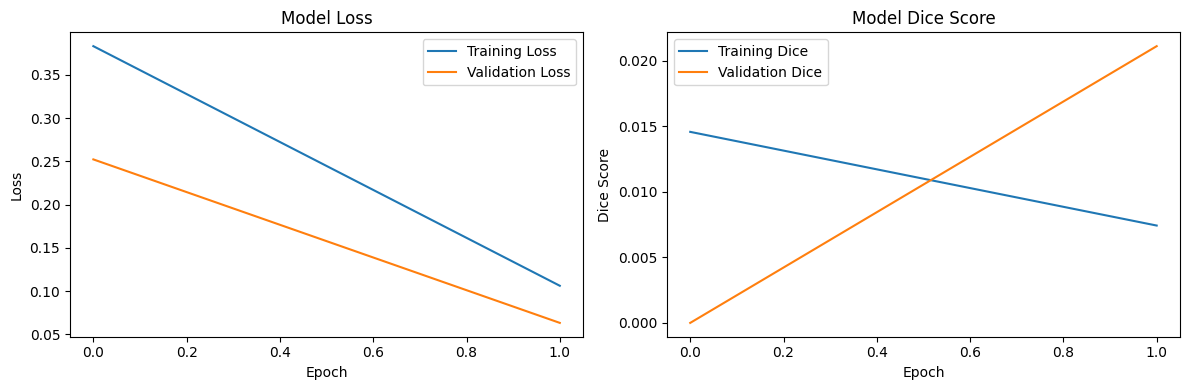

In [ ]:
# Define callbacks
callbacks = [
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_dice', mode='max'),
    EarlyStopping(monitor='val_dice', patience=10, mode='max'),
    ReduceLROnPlateau(monitor='val_dice', factor=0.1, patience=5, mode='max')
]


# Calculate steps per epoch based on dataset size and batch size
# train_steps = len([f for f in os.listdir(os.path.join("processed_data/train", 'ct_scans')) if f.endswith('.npy')]) // 64
train_steps = len([f for f in os.listdir("processed_data/train/ct_scans") if f.endswith('.npy')]) // 64

print(train_steps)
# val_steps = len([f for f in os.listdir(os.path.join("processed_data/test", 'ct_scans')) if f.endswith('.npy')]) // 64
val_steps = len([f for f in os.listdir("processed_data/test/ct_scans") if f.endswith('.npy')]) // 64

print(val_steps)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=2,
    validation_data=test_generator,
    validation_steps=val_steps,
    callbacks=callbacks
)



# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coefficient'], label='Training Dice')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice')
plt.title('Model Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# save model and its architecture
model.save('model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Accuracy: 1.0000
Dice Coefficient: 0.0000


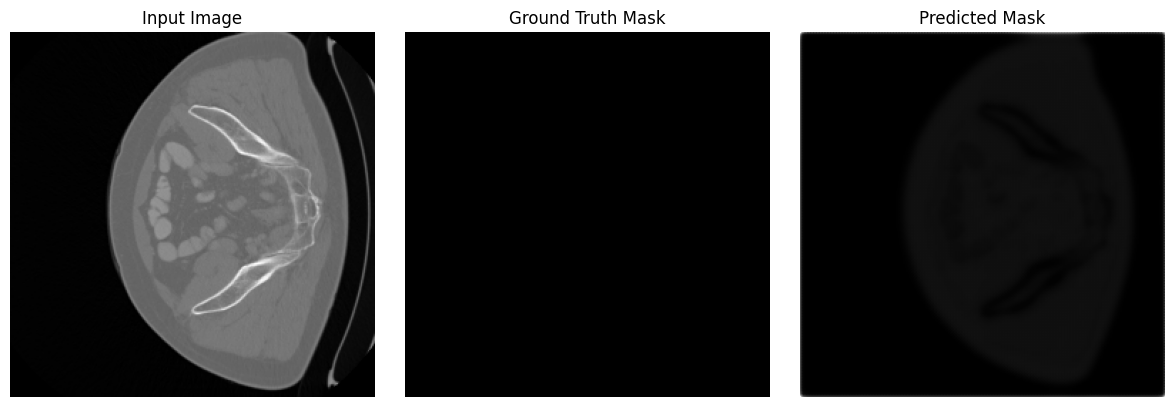

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

# Define the custom Dice coefficient for model loading
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Load the trained model
model = load_model('model.h5', custom_objects={'dice_coefficient': dice_coefficient})

# Function to preprocess the image
def preprocess_image(image_path):
    image = np.load(image_path)  # Load the image as a NumPy array
    image = np.expand_dims(image, axis=-1)  # Add channel dimension if needed
    image = np.expand_dims(image, axis=0)   # Add batch dimension
    return image

# Function to compute metrics
def compute_metrics(y_true, y_pred):
    # Binarize predictions
    y_pred = (y_pred > 0.5).astype(np.float32)

    # Compute Dice coefficient
    intersection = np.sum(y_true * y_pred)
    dice = (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-6)

    # Compute accuracy
    accuracy = np.sum(y_true == y_pred) / y_true.size

    return accuracy, dice

# Function to test the model
def test_model(image_path, mask_path):
    # Preprocess the input image
    input_image = preprocess_image(image_path)

    # Load the ground truth mask
    ground_truth_mask = np.load(mask_path)

    # Predict the mask
    predicted_mask = model.predict(input_image)

    # Squeeze the batch and channel dimensions for visualization and metrics
    input_image = input_image.squeeze()
    ground_truth_mask = ground_truth_mask.squeeze()
    predicted_mask = predicted_mask.squeeze()

    # Compute metrics
    accuracy, dice = compute_metrics(ground_truth_mask, predicted_mask)

    # Print the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")

    # Plot the images
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(input_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth Mask')
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(predicted_mask, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Paths to the sample CT scan and its mask
sample_image_path = '/content/processed_data/test/ct_scans/volume-121_slice_99.npy'
sample_mask_path = '/content/processed_data/test/masks/volume-121_slice_99.npy'

# Test the model
test_model(sample_image_path, sample_mask_path)